In [35]:
#%%
# Import required modules
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.distributions.independent import Independent
from lightning_data_modules.SyntheticDataset import SyntheticDataModule
from lightning_modules.BaseSdeGenerativeModel import BaseSdeGenerativeModel
from lightning_modules.FokkerPlanckModel import FokkerPlanckModel
from lightning_modules.ConservativeSdeGenerativeModel import ConservativeSdeGenerativeModel
from models.fcn import FCN
from models.fcn_potential import FCN_Potential
from models.utils import get_score_fn
from utils import compute_divergence, compute_grad, compute_curl
from plot_utils import plot_log_energy

# Functions

In [36]:
def gt_nomalizing_constant(log_energy_fn, ts=None):

    # Create grid
    d=10
    n=500
    dx = 2*d/n
    c=[0,0]
    x = np.linspace(-d + c[0], d + c[0], n)
    y = np.linspace(-d + c[1], d + c[1], n)
    # Meshgrid
    X,Y = np.meshgrid(x,y)
    XYpairs = np.stack([ X.reshape(-1), Y.reshape(-1) ], axis=1)
    XYpairs_tensor = torch.from_numpy(XYpairs) + 1e-10 # for numerical stability
    XYpairs_tensor=XYpairs_tensor.float()

    # integrate for each t
    total_energies = []
    eps = 1e-5
    ts  = np.linspace(eps, 1- eps, 100)
    for t in ts:
        t=torch.tensor([t]*len(XYpairs_tensor)).float()
        log_probs=log_energy_fn(XYpairs_tensor,t).detach().numpy().reshape(n,n)
        P = np.exp(np.float128(log_probs)) # for numerical stalility when P is large
        total_energy_t = np.float128((P * dx **2).sum())
        total_energies.append(total_energy_t)

    return ts, total_energies
    

# Test

In [118]:
from configs.jan.circles.experiments.fp_circles import get_config
#from configs.jan.gaussian.fokker_planck_gauss import get_config
config = get_config()
ckpt_path = 'logs/gaussian_bubbles/fokker_planck/proto/fp_1e-3/checkpoints/best/last.ckpt'
#ckpt_path = 'logs/gaussian_bubbles/fokker_planck/fp_grad-alpha_0/checkpoints/best/last.ckpt'
ckpt_path ='logs/circles/fokker_planck/proto/fp_1e-3/checkpoints/best/epoch=12102--eval_loss_epoch=6.551.ckpt'
#ckpt_path = 'logs/circles/fokker_planck/proto/potential/checkpoints/best/epoch=9718--eval_loss_epoch=6.717.ckpt'


model = FokkerPlanckModel.load_from_checkpoint(ckpt_path)
model.configure_sde(config)
model = model.eval()
score_model = model.score_model

import pytorch_lightning as pl
pl.seed_everything(42)


Global seed set to 42


42

In [119]:
config = get_config()
data_m = SyntheticDataModule(config)
data_m.setup()
gaussian_bubbles = data_m.dataset

In [120]:
log_energy_fn = lambda x,t: score_model.log_energy(x,t)
ts, total_energies = gt_nomalizing_constant(log_energy_fn)

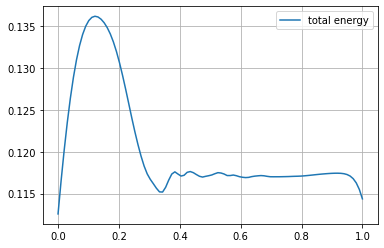

In [121]:
plt.plot(ts, total_energies, label = 'total energy')
plt.grid()
#plt.ylim(0,0.15)
plt.legend()
plt.savefig('figures/A/total_energy', dpi=300)

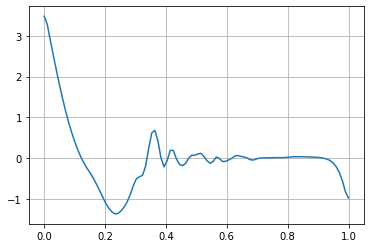

In [122]:
grad_Ct = np.gradient(np.array(np.log(total_energies)), 0.01)
plt.plot(ts, grad_Ct)
plt.grid()

In [123]:
def A(model, x,t):
    diffusion = model.sde.sde(torch.zeros_like(x), t)[1]
    grad_norm_2 = torch.linalg.norm(model.score_model.score(x, t), dim=1)**2

    score_x = lambda y: model.score_model.score(y,t)
    divergence = compute_divergence(score_x, x, hutchinson=False)    
    
    log_energy_t = lambda s: model.score_model.log_energy(x, s) 
    time_derivative = compute_grad(log_energy_t, t).squeeze(1)

    difference = ((diffusion**2 / 2) * (grad_norm_2 + divergence) - time_derivative)
    #difference = diffusion**2 * difference # apply weighting
    return difference

In [124]:
x = gaussian_bubbles.data[:10000]
t = float(0)
t_tensor = torch.tensor([t]*len(x))
perturbed_data = model.sde.perturb(x, t_tensor) # WARNING P
print('mean:', A(model, perturbed_data, t_tensor).mean().item())
print('std:', A(model, perturbed_data, t_tensor).std().item())

mean: -2.0766730308532715
std: 1.634456992149353


In [125]:
grad_Ct_estimate = []
eps = 1e-5
ts  = np.linspace(eps, 1 - eps, 100)
for t in ts:
    x = gaussian_bubbles.data[:10000]
    t = float(t)
    t_tensor = torch.tensor([t]*len(x))
    # diffusion = model.sde.sde(torch.zeros_like(batch), t)[1]
    # oneish = (1.0- eps) * torch.ones_like(t).to(model.device)
    perturbed_data = model.sde.perturb(x, t_tensor) # WARNING P
    grad=-A(model, perturbed_data, t_tensor).mean().item()
    grad_Ct_estimate.append(grad)

KeyboardInterrupt: 

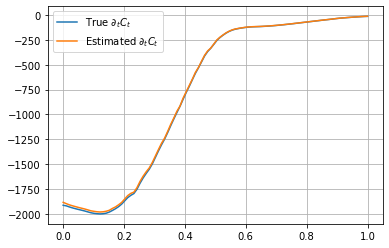

In [ ]:
plt.plot(ts, grad_Ct, label='True $\partial_t C_t$')
plt.plot(ts, grad_Ct_estimate, label='Estimated $\partial_t C_t$')
plt.legend()
plt.grid()
plt.savefig('figures/A/gradCt', dpi=300)

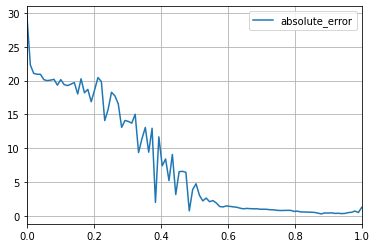

In [ ]:
#plt.bar(ts,  np.abs(np.log(total_energies) - C_t.y[0, ::-1]) / np.abs(np.log(total_energies)), label='relative error')
plt.plot(ts,  np.abs(grad_Ct - grad_Ct_estimate) , label='absolute_error')
plt.xlim(0,1)
plt.grid()
plt.legend()
plt.savefig('figures/A/abs_error_gradCt', dpi=300)

In [ ]:
difs = []
eps = 1e-5
ts  = np.linspace(eps, 1 - eps, 100)
for t in ts:
    x = gaussian_bubbles.data[:10000]
    t = float(t)
    t_tensor = torch.tensor([t]*len(x))
    # diffusion = model.sde.sde(torch.zeros_like(batch), t)[1]
    # oneish = (1.0- eps) * torch.ones_like(t).to(model.device)
    perturbed_data = model.sde.perturb(x, t_tensor) # WARNING P
    dif=(A(model, perturbed_data, t_tensor).detach() - grad_Ct[list(ts).index(t)]).abs().mean().item()
    difs.append(dif)

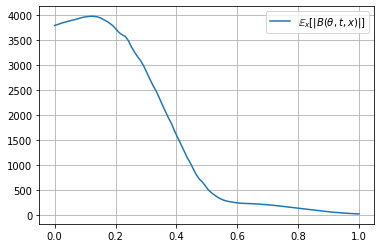

In [ ]:
plt.plot(ts, difs, label='$\\mathbb{E}_{x}[|B(\\theta, t, x)|]$')
plt.grid()
plt.legend()
plt.savefig('figures/A/fp_error', dpi=300)
plt.show()

In [ ]:
def ode(t, x):
    x = gaussian_bubbles.data[:10000]
    t = float(1-t)
    t_tensor = torch.tensor([t]*len(x))
    perturbed_data = model.sde.perturb(x, t_tensor)
    grad=A(model, perturbed_data, t_tensor).mean().item()
    return grad 

In [ ]:
from scipy import integrate
init = np.array([np.log(total_energies[-1])])
C_t = integrate.solve_ivp (ode, (eps, 1 -  eps), init, t_eval=ts)

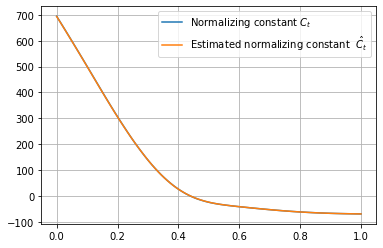

In [ ]:
plt.plot(ts, np.log(total_energies), label = 'Normalizing constant $C_t$')
plt.plot(ts, C_t.y[0, ::-1], label = 'Estimated normalizing constant  $\hat{C_t}$')
plt.grid()
#plt.ylim(0, 0.15)
plt.legend()
plt.savefig('figures/A/Ct', dpi=300)

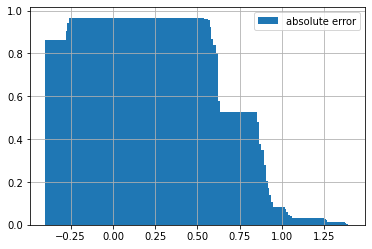

In [ ]:
#plt.bar(ts,  np.abs(np.log(total_energies) - C_t.y[0, ::-1]) / np.abs(np.log(total_energies)), label='relative error')
plt.bar(ts,  np.abs(np.log(total_energies) - C_t.y[0, ::-1]) , label='absolute error')
plt.grid()
plt.legend()

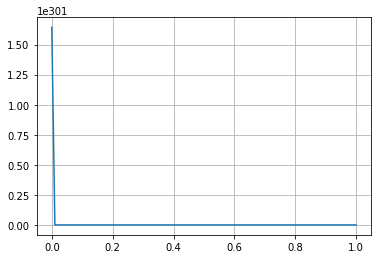

In [ ]:
y = np.exp(C_t.y[0, ::-1])
plt.plot(C_t.t, y)
plt.grid()

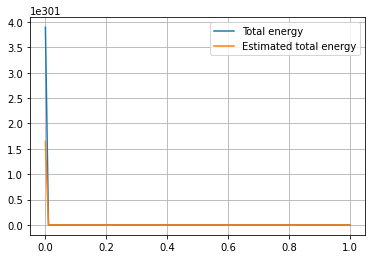

In [ ]:
plt.plot(ts, total_energies, label = 'Total energy')
plt.plot(ts, y, label = 'Estimated total energy')
plt.grid()
#plt.ylim(0, 0.15)
plt.legend()

In [ ]:
log_energy_fn = lambda x,t: score_model.log_energy(x,t) - C_t.y[0, ::-1][list(ts).index(t[0])]
ts, total_energies_normalized = gt_nomalizing_constant(log_energy_fn)

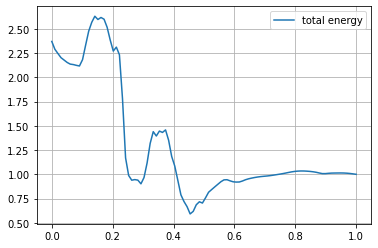

In [ ]:
plt.plot(ts, total_energies_normalized, label = 'total energy')
plt.grid()
#plt.ylim(0,0.15)
plt.legend()
plt.savefig('figures/A/total_energy_normalized', dpi=300)